# Lecture 1: Introduction to PySpark

Immagine you are interested in working on a large dataset, at the scale of Petabytes:

* Data are distributed in many nodes, collecting all of them in one node would be impossible

* You want to first load data and explore them

* Before moving to machine learning you need to preprocess data

What you would like to do is run the preprocessing on each node and return only some high level quantities that will be used in the analysis. 

This is the core concept of Hadoop and Spark: the code goes to the data rather than the data coming to the machine where the code resides. 


# Standalone Cluster

For this set of lectures we will work with a standalone cluster deployed on your machine. You can use it to develop and test your application before deploying it on a large cluster.

Youc can choose to:
* **Local cluster**: Create a local cluster by downloanding and configuring all components by hand
* **Single docker container**: Use the provided docker image to do the same
* **Docker cluster**: Create a cluster using multiple docker containers

Run the setup only for the version you are interested and set the following variable.
Note that if you want to use docker you need to be running this notebook from inside a container, 
following the instructions reported in the README

In [1]:
# set this variable with one of the following values
# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'
CLUSTER_TYPE ='docker_container'

# Local Cluster

<center><img src='imgs/lecture1/standalone_cluster.png'/></center>


### Prerequisites

* Download [spark](https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz) 

* Extract the spark tar with `tar xvf spark-3.1.1-bin-hadoop3.2.tgz`

* Spark 3 should run on both Java 8/11, so make sure that you have one of them as default (or `JAVA_HOME` environment variable pointing to your java installation)

* If this is set correctly, typing `java -version` on your terminal shoud display something like `openjdk version "1.8.0_252"`

### Create a standalone cluster

We will now create a Spark standalone cluster on our local machine. More on this can be found in the [spark documentation](https://spark.apache.org/docs/latest/spark-standalone.html). 

First we need to start the master: to do this, move into the spark directory, i.e. `cd spark-3.1.1-bin-hadoop3.2`. From here run the following command 
```
./sbin/start-master.sh --host localhost --port 7077 --webui-port 8080
```
This will spin up the spark master with address `spark://localhost:7077` and a cluster dashboark at `localhost:8080`.

We can now create a worker with:

```
./sbin/start-worker.sh spark://localhost:7077 --cores 2 --memory 2g
```

After a few seconds it should appear in the master’s web UI. 

**Note**: ther can be at most one worker per each node, i.e. you can't start two workers. 


### Running applications

We can now submit our application to the cluster with commands such as `spark-submit`. For these sessions we will use jupyter-notebooks to explore pyspark interactively. To do this we need one last package wich will set the environment variables needed to get pyspark modules and use the correct version of python. 

The package can be installed via pip running the following cell

In [1]:
!pip install findspark

You should consider upgrading via the '/Users/matteo/miniconda3/bin/python -m pip install --upgrade pip' command.


We can now initialize all the required variables with `findspark.init()` by passing the path to the spark folder we downloaded previously.

In [3]:
import findspark

findspark.init('/Users/matteo/Work/MAPD/spark-3.1.1-bin-hadoop3.2/')

In [4]:
# check some of the env variables
!env | grep -i spark

SPARK_HOME=/Users/matteo/Work/MAPD/spark-3.1.1-bin-hadoop3.2/
PYSPARK_PYTHON=/Users/matteo/miniconda3/bin/python


# Single docker container

If you are opening this notebook using the provided container all environment variables are already set. 
It is the possibile to start master and workers with the following bash commands

In [2]:
!$SPARK_HOME/sbin/start-master.sh --host localhost --port 7077 --webui-port 8080

starting org.apache.spark.deploy.master.Master, logging to /usr/bin/spark-3.1.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.master.Master-1-065dcfffd35d.out


In [3]:
!$SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 --cores 2 --memory 2g

starting org.apache.spark.deploy.worker.Worker, logging to /usr/bin/spark-3.1.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.worker.Worker-1-065dcfffd35d.out


Now the cluster dashboard is available at `localhost:8080`.

# Docker cluster

If the cluster has been created with docker compose there is nothing to do. The cluster dashboard can be seen at `localhost:8080` and the master is already available at `spark://spark-master:7077`.

# Spark Session

We can now create the spark session. With the following command we are asking to the master (and resource manager) to create an application with required resources and configurations. In this case we are using all the default options, e.g. number of core and number of executors, but we can also specify some of them with `.config("spark.some.config", "value")`. The list of available configurations can be found [here](https://spark.apache.org/docs/latest/configuration.html).

In [4]:
from pyspark.sql import SparkSession

if CLUSTER_TYPE in ['local', 'docker_container']:
    
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .getOrCreate()

elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .getOrCreate()
else:
    print("Variable CLUSTER_TYPE is not set.")

In [5]:
spark

In [6]:
# get spark context -> entry point used to work with RDD
sc = spark.sparkContext
sc

<SparkContext master=spark://localhost:7077 appName=First spark application>

## Parallelize!

The first command we will se is `parallelize()`. This function of the `SparkContext` (`sc`) is used to create a Resilient Distributed Datasets (**RDD**) from a list collection. In other words it takes a collection and split it amongst the worker. We will use it to get familiar with the main functions of spark RDDs. 

Starting from `python_dataset` we create an RDD, `dist_data`, and then operate on it in a parallel fashion.

In [7]:
# python dataset
data = [1,2,3,4,5,6,7,8]

# parallelize
dist_data = sc.parallelize(data)

... nothing happend in the Web UI! that's because `parallelize` is not an action. We can trigger it using `count`, a function used to count the number of elements in the rdd. 

In [8]:
# count elements of the rdd
dist_data.count()

8

If you are using two cores, in the WebUI you will see two parallel lines for this task. That's because the RDD consists of two *partitions*. Indeed, under the hood, RDD are stored and represented as partitions, "small blocks" of the original dataset that will be **unit of parallelism**.

<br/><center><img src='imgs/lecture1/rdd_partitions.png'/></center><br />


In other words if we have two cores in our worker, but the RDD is composed of one partitions, then only one task at the time will be run. On the other hand, if the partitions are four only two of them will be processed in parallel.


<br/><center><img src='imgs/lecture1/partitions_processing.png'/></center><br/>

In [9]:
# parallelize using a different number of partitions
sc.parallelize(data, numSlices=4).count()

8

In [10]:
sc.parallelize(data, numSlices=4).getNumPartitions()

4

In [11]:
# get the number of partitions
dist_data.getNumPartitions()

2

With `collect()` a distributed dataset is collected in the driver, i.e. all workers will send back the blocks. This is generally used to collect the results of the processing. This function should be used with caution since it fetches the entire RDD to a single machine and can cause the driver to run out of memory. 

In [12]:
# collect the data_rdd
dist_data.collect()

[1, 2, 3, 4, 5, 6, 7, 8]

## Map and Reduce

We can now write our first map-reduce application. the method `map(f)` will apply the function `f` to each element of the rdd. 

In [13]:
# increment each number of the array with map
# and collect the result
dist_data.map(lambda x: x+1).collect()

[2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
# multiple map transformation
dist_data.map(lambda x: x+1).map(lambda x: x/2).collect()

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

`reduce` is an action that aggregates all the elements of the RDD using some function and returns the result to the driver. We will see later on a version of reduce, `reduceByKey`, wich performs the reduction for elements with the same key. `reduceByKey` is not an action since it return a distributed dataset since the result of this aggregation could still be large if the number of keys is large.  

In [15]:
# increment each number of the dataset and sum 
# all of them
dist_data.map(lambda x: x+1).reduce(lambda x1, x2: x1+x2)


44

A schematic view of this simple map-reduce application can be seen here:

<br/><center><img src='imgs/lecture1/map_reduce_increment.png'/></center><br/>

## Exercize 1

Write a reduce function to find the minimum of `data_rdd`.

In [16]:
dist_data.reduce(lambda x,y: min(x,y))

1

In [17]:
dist_data.reduce(min)

1

## Exercise 2 - compute $\pi$

It is possible to estimate $\pi$ by simulating random points in the unit square (side length of $1$) and counting how many fall in the unit circle. The probability of one point falling inside the circle is 

$$
P = \frac{\text{Area circle}}{\text{Area square}} = \frac{\pi}{4}
$$

We can estimate this probabiliy by counting the number of simulated points inside the circle

$$
P = \frac{\text{#Points in circle}}{\text{#Points}} 
$$

bbtaining 

$$
\pi \approx 4 \cdot \frac{\text{#Points in circle}}{\text{#Points}}
$$

<br/><center><img src='imgs/lecture1/pi_estimation.png'/></center><br/>

This can be done in Spark with the following steps:
1. Create the "dummy rdd" containing the placeholders for the points
2. Generate the points and check if each of them is inside the circle
3. Count the points inside the circle

In [18]:
import random

num_points = 100000

## instantiate "placeholder RDD"
points_rdd = sc.parallelize([0]*num_points)

def in_circle(dummy):
    ## simulate the point and check if
    ## it is inside the circle 
    ## return 0 or 1
    x = random.random()
    y = random.random()
    
    return 1 if x**2+y**2 <= 1 else 0

# count points inside the circle
count_circle = points_rdd.map(in_circle).reduce(lambda n1, n2: n1+n2)

# print result
print("Pi: {:.4f}".format(4*count_circle/num_points))

Pi: 3.1394


The same result can be achieved using the `filter` transformation. `filter(f)` returns a new RDD containing only the element of source RDD on which `f` is true.

In [19]:
# perform the same exercise using filter
count_circle = points_rdd \
    .map(lambda x: (random.random(), random.random())) \
    .filter(lambda p: p[0]**2+p[1]**2 <= 1) \
    .count()

print("Pi: {:.4f}".format(4*count_circle/num_points))

Pi: 3.1379


## Reduce by key and flat map 

Consider the following dataset where each element consists of a tuple `(group, value)` (**key-value pair**). This can be for example group = product class and value = revenue

In [20]:
class_list = [('group1', 10), ('group2', 4), ('group3', 1), ('group2', 7), ('group1', 8)]
class_rdd = sc.parallelize(class_list)

We could be interested in operating only on values

In [21]:
# operate only on the values
class_rdd.map(lambda el: (el[0], el[1]+1)).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

The same result can be achieved using `mapValues`

In [22]:
# do the same using map values
class_rdd.mapValues(lambda x: x+1).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

We can perform a reduce function for each class using `reduceByKey`: in this way we are applying the reduce function only to the elements of the same class

In [23]:
# compute the minimum using reduce by key
class_rdd.reduceByKey(lambda x, y: min(x,y)).collect()

[('group1', 8), ('group3', 1), ('group2', 4)]

In [24]:
class_rdd.reduceByKey(lambda x, y: min(x,y)) \
    .takeOrdered(2, key=lambda x: -x[1])

[('group1', 8), ('group2', 4)]

If we are not interested in treating the dataset as key-value pairs, or in general we have a non-flat dataset (e.g. each element of the RDD is a list), we can use `flatMap` to "decompose" each element. The function of this map must return a sequence.

In [25]:
# flatten the rdd
class_rdd.flatMap(lambda el: el).collect()

['group1', 10, 'group2', 4, 'group3', 1, 'group2', 7, 'group1', 8]

In [26]:
sc.parallelize([[1,2,3], [2,3,4]]) \
    .flatMap(lambda x: x) \
    .collect()

[1, 2, 3, 2, 3, 4]

## Exercise 3: word count

You have received the following message from one of your friend: 

In [27]:
message = [
    'One ring to rule them all, ? one ring to find them,\n',
    'One ring $ to bring them all, and in the % darkness bind them;\n',
    'In the Land of Mordor @ where the shadows lie.'
]

print(''.join(message))

One ring to rule them all, ? one ring to find them,
One ring $ to bring them all, and in the % darkness bind them;
In the Land of Mordor @ where the shadows lie.


You are interested in comping the occurence of each word, but first you need to clean the message (e.g remove symbols such as `@` and `$`) and change all the words to lower case.

In [28]:
# parallelize the message
message_rdd = sc.parallelize(message)
message_rdd.collect()

['One ring to rule them all, ? one ring to find them,\n',
 'One ring $ to bring them all, and in the % darkness bind them;\n',
 'In the Land of Mordor @ where the shadows lie.']

Hint: use `string.punctuation` or a regular expression to remove the unwanted character

In [29]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
# step 1: create the words_rdd where each element is a word
# eg: ['one', 'ring', 'to', 'rule', 'them']

def clean_row(row):
    # clean the row and return the list of words
    word_list = []
    
    ## Code
    for word in row.strip().split():
        clean_word = ''
        for char in word:
            if char not in string.punctuation:
                clean_word += char
        if clean_word!="":
            word_list.append(clean_word.lower())
    ##
    
    return word_list

# apply transformation
words_rdd = message_rdd.flatMap(clean_row)
words_rdd.collect()[:10]

['one', 'ring', 'to', 'rule', 'them', 'all', 'one', 'ring', 'to', 'find']

In [33]:
# step 2: perform word count!
# -> crate pairs (word, 1)
# -> reduce and count

word_count_rdd = words_rdd.map(lambda word: (word, 1)) \
    .reduceByKey(lambda c1, c2: c1+c2)
word_count_rdd.collect()

[('rule', 1),
 ('them', 4),
 ('bring', 1),
 ('in', 2),
 ('bind', 1),
 ('of', 1),
 ('mordor', 1),
 ('where', 1),
 ('shadows', 1),
 ('lie', 1),
 ('one', 3),
 ('ring', 3),
 ('to', 3),
 ('all', 2),
 ('find', 1),
 ('and', 1),
 ('the', 3),
 ('darkness', 1),
 ('land', 1)]

The method `takeOrdered(n, key)` allows to collect only the first $n$ elements based on the ordering provided by key. Ordering is by default ascendent. 

In [34]:
# collect the 3 most occurent words
word_count_rdd.takeOrdered(3, key=lambda x: -x[1])

[('them', 4), ('one', 3), ('ring', 3)]

## Exercise 4 - Linear regression

The files in `../datasets/lecture1/` contain the measure of a sensor. Each measure is in the form 

```
Measure  N: (t,val)
```

There could be pairs such as `(t, None)`, corresponting to missing values. This measure should be removed. 

We are interested in knowing if there is any sort of relation between `t` and `val`.

The first task consits in reading each file and creating an RDD containing as element the pairs `(t,val)`.

In [35]:
!head ../datasets/lecture1/file_1.txt

Measure  0: (-10.00,0.70)
Measure  1: (-9.95,0.61)
Measure  2: (-9.90,0.47)
Measure  3: (-9.85,None)
Measure  4: (-9.80,0.58)
Measure  5: (-9.75,0.29)
Measure  6: (-9.70,0.35)
Measure  7: (-9.65,0.25)
Measure  8: (-9.60,0.39)
Measure  9: (-9.55,0.52)


Imagine that each file contain millions of measure and there may be hundreds of files. Furhermore data can be partitioned in multiple nodes. For this reasons reading all the files with python and then using `parallelize` should be avoided. 

We can parallelize the list of files and then read them in parallel with spark. 

In [36]:
if CLUSTER_TYPE=='local':
    base_path = '/Users/matteo/Work/MAPD/notes/MAPD2021/datasets/lecture1/file_{}.txt'
else:
    base_path = '/opt/workspace/datasets/lecture1/file_{}.txt'
file_list = [base_path.format(i) for i in range(1,5)]

files_rdd = sc.parallelize(file_list)
files_rdd.collect()

['/opt/workspace/datasets/lecture1/file_1.txt',
 '/opt/workspace/datasets/lecture1/file_2.txt',
 '/opt/workspace/datasets/lecture1/file_3.txt',
 '/opt/workspace/datasets/lecture1/file_4.txt']

#### Note
In this case we could have used the function `textFile`, which takes as input the path to the files and read them into an RDD. To access a file in with this function we need to prepend `file://` if the file is in the local file system. If the file is in hadoop the path will be similar to `hdfs://namenode.com:8020/path_to_the_file`. In the same way, if the file is stored in `s3` the path will be `s3://`.

The function `textFile` can be used in this case only because files are stored in `.txt` files, and in many cases a custom data loader is required. On the other hand, we should try to use this function as much as possible since they are much more performant than standard python code.  

However, in this example we will wire a custom data loader. 

In [37]:
text_rdd = sc.textFile("file://"+base_path.format('*'))
text_rdd.collect()[:4]

['Measure  0: (-10.00,0.70)',
 'Measure  1: (-9.95,0.61)',
 'Measure  2: (-9.90,0.47)',
 'Measure  3: (-9.85,None)']

Starting from the RDD files, write a map that convert it into an RDD, `data_rdd`, where each element is a touple `(t, val)`. Remember to remove points with `None` measure. The elements of `data_rdd` should be something like

```
[(0.0,9.93), (-1.0,9.02), ...]
```

In [1]:
import re

line_ = 'Measure  0: (.05,0.70)'
#float_pattern = '[-+]?(?:(?:\d*\.\d+)|(?:\d+))'
float_pattern = '-?[0-9]*\.[0-9]*'
#coordinates = re.findall(f'{float_pattern},{float_pattern}', line_)
#coordinates   
re.findall('-?[0-9]*\.[0-9]*', line_)

['.05', '0.70']

In [57]:
import re

def parse_file(file):
    
    ## load lines 
    with open(file, 'r') as fin:
        lines = fin.readlines()
        
    points = []
    ## extract points
    for line in lines:
        float_pattern = '[-+]?(?:(?:\d*\.\d+)|(?:\d+))'
        coordinates = re.findall(f'{float_pattern},{float_pattern}', line)
        
        if len(coordinates)!=0:
            coordinates = coordinates[0].split(',')
            points.append(
                (float(coordinates[0]), float(coordinates[1]))
            )
    ## 
    return points

data_rdd = files_rdd.flatMap(lambda file: parse_file(file))
data_rdd.collect()[:10]

[(-10.0, 0.7),
 (-9.95, 0.61),
 (-9.9, 0.47),
 (-9.8, 0.58),
 (-9.75, 0.29),
 (-9.7, 0.35),
 (-9.65, 0.25),
 (-9.6, 0.39),
 (-9.55, 0.52),
 (-9.5, 0.68)]

With `sample(with_replacement, fraction)` we can sample some points from the original RDD. This is usefull if we want to collect only a fraction of data

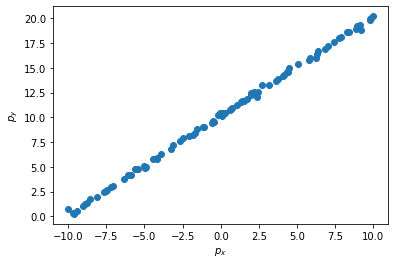

In [59]:
import matplotlib.pyplot as plt 
import numpy as np

# collect a sample
data = np.array(data_rdd.sample(False,0.2).collect())

plt.scatter(data[:,0], data[:,1])

plt.xlabel(r'$p_x$')
plt.ylabel(r'$p_y$')
plt.show()

We will now implement a distributed gradient descent and use it to find the best parameters for a linear model. Given an input $X$ the ouput of the model is 

$$
Y = W X = w_{0} + w_1 x_1 + \dots + w_p x_p
$$

In our case we have $Y=y(w,x)$, $W = [w_0, w_1]$ and $X=[1, x]^T$, in other words

$$
y(w,x) = w_0 + w_1 x
$$

We are interested in estimating the optimal parameters $w^\star$ of the line fitting our data. To do this we will use gradient descent, an iterative procedure that allows us to find a local minumum of a differentiable function.

In our case, we would like to minimize the square residuals, i.e.

$$
J(W,X) = \frac{1}{2n} \sum_{i=1}^{n} [Y(W, X)- y_i]^2 = \frac{1}{2n} \sum_{i=1}^{n} [ (w_0 +w_1x) - y_i]^2
$$

where $y_i$ is the true value. 

In each step of the gradient descent we use the following update rule

$$
W_{i+1} = W_i - \gamma \nabla J_W(W_i, X)
$$

where $\gamma$ is the learning rate, a variable used to reduce the size of each step.
In other word we are moving in the opposite direction of the gradient, i.e. towards the minimum of the function. 

Recalling that $W=[w_0, w_1]$ and $X=[1,x]$ we have that each component of the gradient, i.e. $\frac{\partial}{\partial w_p} J(W,X) $

$$
\nabla J(W, X) = \left[\frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot1, \frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot x_i \right]
$$


We can now write a map-reduce job used to estimate the parameters using gradient descent on the full dataset.

We start by defining the weights vector and initializing it to some values, e.g. $(10, 1)$ is a good guess :)

In [60]:
import numpy as np

W = np.array([10, 0.5])

Implement then the functions computing the prediction given as input $x$ and the current weights W

In [61]:
def predict(x, W):
    ## return prediction
    return W[0] + W[1]*x
    

# test the function
assert predict(1, [10,1]) == 11

Implement the function computing the gradient for one example given as input the point $P=(x,y)$ and the current set of weights $W$. Remember that the gradient has two components, one per parameter. Furthermore the normalization $\frac{1}{n}$ can be ommited since we can apply it after having summed the gradients of all examples. 

In [62]:
def gradient(P, W):
    pred = predict(P[0], W)
    
    ## compute gradient
    gradient = np.dot(pred-P[1], [1,P[0]])
    return gradient

# test the function
assert not (gradient((1,11), [10,1])).all() 

We are now ready to implement the gradient descent and find the optimal line parameters. 

**Hint**: compute the gradient for each point and them sum all of them. Use this sum to update the weights. 

In [63]:
# count points
num_points = data_rdd.count()

# copy weights here: this is usefull if the
# cell is run multiple times
W = np.array([10,0.5])

lr = 0.01
num_it = 20

for i in range(num_it):
    ## code
    grad = data_rdd.map(lambda P: gradient(P,W)).reduce(lambda g1,g2: g1+g2)
    W = W - (lr/num_points)*grad
    ##
    
print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

Final parameters: x0=10.03, x1=1.00


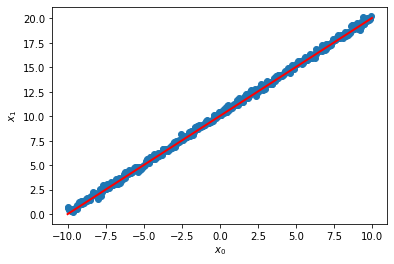

In [64]:
import matplotlib.pyplot as plt

data = np.array(data_rdd.collect())

plt.scatter(data[:,0], data[:,1])

x = np.arange(-10,11)
y = W[0] + W[1]*x

plt.plot(x, y, color='red', lw=2)

plt.xlabel(r'$x_{0}$')
plt.ylabel(r'$x_{1}$')

plt.show()

### Caching

From the WebUI we can see that in each iteration Spark is comping everything from the beginning, i.e. the parallelization of the text files. With `cache()` we can tell spark to cache the intermediate results, e.g. after the function parsing the files. 

In this way the same dataset will be loaded in the next iterations at the cost of having the dataset stored in memory. 

**Note:** to be precise, there could be different levels of [persistence](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence).

The RDD can be unpersisted with `unpersist()`.

Performe the gradient descent iterations again by caching `data_rdd` ad look at the WebUI.

In [66]:
data_rdd = data_rdd.persist()

## previous code
# count points
num_points = data_rdd.count()

# copy weights here: this is usefull if the
# cell is run multiple times
W = np.array([10,0.5])

lr = 0.01
num_it = 20

for i in range(num_it):
    ## code
    grad = data_rdd.map(lambda P: gradient(P,W)).reduce(lambda g1,g2: g1+g2)
    W = W - (lr/num_points)*grad
    ##  
## 

data_rdd = data_rdd.unpersist()

print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

Final parameters: x0=10.03, x1=1.00


## Residuals

Compute the residuals usign spark. The residual of the point $(x_i, y_i)$ with respect to the model $y(x)$ is defined as

$$
R_i = y(x_i) - y_i
$$

In [ ]:
residuals_rdd = 

In [ ]:
plt.hist(residuals_rdd.collect(), bins=10)
plt.show()

# Stop worker and master

In [67]:
sc.stop()

In [68]:
spark.stop()

### Local cluster and single docker_container 

for docker it is sufficient to close the container.

In [69]:
!$SPARK_HOME/sbin/stop-worker.sh

stopping org.apache.spark.deploy.worker.Worker


In [70]:
!$SPARK_HOME/sbin/stop-master.sh

stopping org.apache.spark.deploy.master.Master
